In [1]:
#NLP project - IMDB - topic modeling
#https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
#https://github.com/RaRe-Technologies
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
#https://github.com/lda-project/lda
#https://github.com/derekgreene/dynamic-nmf
#https://nlpforhackers.io/topic-modeling/
#https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
#https://docs.python.org/2/library/re.html
#https://pythonspot.com/nltk-stop-words/
#https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html
#https://textblob.readthedocs.io/en/dev/advanced_usage.html
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#https://rare-technologies.com/tutorial-on-mallet-in-python/

In [2]:
import nltk
import gensim
import logging
import os
import re
import gensim
import spacy
import pyLDAvis
import en_core_web_sm
import warnings
import numpy as np
import pandas as pd
import gensim.corpora as corpora
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models.word2vec import Word2Vec
import pyLDAvis.sklearn
import pyLDAvis.gensim  # don't skip this

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from nltk.corpus import stopwords
#from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV


from muffnn import MLPClassifier
from pprint import pprint
from spacy.lang.en import English

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\louis\Anaconda2\envs\py3.6\lib\site-packages\google\protobuf\descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message
C:\Users\louis\Anaconda2\envs\py3.6\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):


In [3]:
df_review=pd.read_excel("../CannaConnect/Dataset/description_clean.xlsx")
df_review=df_review.iloc[:,1]
df_review.head()

0     og   hybrid pack strong punch name supposedly...
1     aloha white widow especially potent cut white...
2     sativa hybrid bred spain medical seed co bree...
3     dawgs hybrid g chemdawg genetics bred canadia...
4    kosher tangie k gold  indica hybrid combine le...
Name: Description, dtype: object

In [4]:
# Convert to list
data = df_review.values.tolist()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['og', 'hybrid', 'pack', 'strong', 'punch', 'name', 'supposedly', 'refers', 'strength', 'high', 'price', 'first', 'started', 'showing', 'hollywood', 'plant', 'og', 'tends', 'produce', 'large', 'dark', 'green', 'bud', 'stem', 'user', 'report', 'strong', 'body', 'indica', 'pain', 'relief', 'alert', 'cerebral', 'feeling', 'thanks', 'sativa', 'side']]


In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = en_core_web_sm.load()

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['hybrid pack strong punch name supposedly refer strength high price first start show hollywood plant tend produce large dark green bud stem user report strong body indica pain relief alert cerebral feel thank sativa side', 'aloha white widow especially potent cut white widow grow renown hawaiian legend maui kona gold white widow phenotype reek diesel skunk rich earthy taste intermittent note hash bud coat trichome give dark foliage lustrous glint go room fill odor hitter quitter uplift mind mind bend euphoria materialize body airy relaxation aloha white widow available pua mana hawaiian pakalolo seed bank']


In [7]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.6332289308076862 %


In [9]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=15, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [10]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -563407.81453443
Perplexity:  862.6667734765914
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 15,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [11]:
# Define Search Param
search_params = {'n_components': [3,5,10,15,20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,cv=3)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                        

In [16]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -194272.8574417136
Model Perplexity:  801.0595352864556


In [17]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.53,0.17,0.3,0
Doc1,0.21,0.29,0.51,2
Doc2,0.01,0.52,0.47,1
Doc3,0.01,0.98,0.01,1
Doc4,0.01,0.11,0.88,2
Doc5,0.14,0.01,0.85,2
Doc6,0.41,0.58,0.01,1
Doc7,0.4,0.59,0.01,1
Doc8,0.24,0.22,0.53,2
Doc9,0.68,0.31,0.01,0


In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,800
1,2,747
2,0,730


In [20]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\louis\Anaconda2\envs\py3.6\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  34.629646
2     -1209.665405  212.164124       2        1  32.742730
0     -1437.453247 -586.322510       3        1  32.627623, topic_info=     Category         Freq        Term        Total  loglift  logprob
1965  Default   361.000000       white   361.000000  30.0000  30.0000
1406  Default   556.000000      purple   556.000000  29.0000  29.0000
1531  Default  1005.000000      sativa  1005.000000  28.0000  28.0000
814   Default   451.000000        haze   451.000000  27.0000  27.0000
1307  Default   295.000000    physical   295.000000  26.0000  26.0000
977   Default   792.000000        kush   792.000000  25.0000  25.0000
391   Default   197.000000       cooky   197.000000  24.0000  24.0000
845   Default   661.000000        high   661.000000  23.0000  23.0000
1652  Default   476.000000        sour   476.000000  22.0000  22.0000
903   Default  1365.000000      indica  1365.000000  21.0000  21.0000
439   Default   211.000000         cup   211.000000  20.0000  20.0000
946   Default   163.000000        jack   163.000000  19.0000  19.0000
493   Default   412.000000      diesel   412.000000  18.0000  18.0000
684   Default   707.000000      flower   707.000000  17.0000  17.0000
379   Default   437.000000    consumer   437.000000  16.0000  16.0000
781   Default   385.000000        grow   385.000000  15.0000  15.0000
1968  Default   129.000000       widow   129.000000  14.0000  14.0000
1323  Default   430.000000       plant   430.000000  13.0000  13.0000
1720  Default   121.000000  strawberry   121.000000  12.0000  12.0000
753   Default   115.000000        girl   115.000000  11.0000  11.0000
200   Default   513.000000       breed   513.000000  10.0000  10.0000
1314  Default   112.000000   pineapple   112.000000   9.0000   9.0000
1802  Default   191.000000     terpene   191.000000   8.0000   8.0000
184   Default   717.000000        body   717.000000   7.0000   7.0000
1319  Default   126.000000       place   126.000000   6.0000   6.0000
591   Default   190.000000       enjoy   190.000000   5.0000   5.0000
1953  Default   301.000000        week   301.000000   4.0000   4.0000
909   Default   224.000000      indoor   224.000000   3.0000   3.0000
1810  Default   380.000000         thc   380.000000   2.0000   2.0000
258   Default   269.000000         cbd   269.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
822    Topic3    82.684761       heady   106.075127   0.8709  -5.7957
1310   Topic3    49.763148         pie    57.368941   0.9778  -6.3034
1260   Topic3   292.773710        pain   545.058906   0.4985  -4.5313
884    Topic3    84.683343       ideal   112.915916   0.8323  -5.7718
555    Topic3    70.654458       earth    89.537812   0.8832  -5.9529
977    Topic3   386.503260        kush   792.844941   0.4015  -4.2536
167    Topic3    86.323967       black   115.823143   0.8261  -5.7526
1706   Topic3   119.353528   stimulate   179.161677   0.7138  -5.4286
287    Topic3   103.741781      cherry   150.855591   0.7456  -5.5688
903    Topic3   517.198948      indica  1365.933054   0.1488  -3.9623
1722   Topic3   186.983644      stress   359.510491   0.4663  -4.9797
1326   Topic3    67.945550    pleasant    86.576224   0.8777  -5.9920
102    Topic3   359.264148       aroma   969.148950   0.1277  -4.3267
1454   Topic3   158.174325  relaxation   297.359052   0.4888  -5.1470
1453   Topic3   160.216259       relax   303.352605   0.4816  -5.1342
923    Topic3    93.952107    insomnia   139.367245   0.7257  -5.6679
1132   Topic3   154.214802        mind   317.849368   0.3968  -5.1724
1768   Topic3   267.115345       sweet   820.888840  -0.0027  -4.6230
774    Topic3   155.278242       green   353.078358   0.2985  -5.1655
879    Topic3   290.996592      hybrid  1258.398641  -0.3443  -4.5374
743    Topic3   207.97

In [21]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abate,ability,abundance,abundant,abusive,acapulco,accent,accentuate,accompany,accord,...,wrap,wreathe,wreck,year,yellow,yield,yielder,yielding,zesty,zombie
Topic0,21.316129,3.395566,2.450076,0.342612,1.387457,0.355899,1.823811,0.348790,7.994443,3.495300,...,10.939776,4.490619,3.636595,0.918949,0.550942,32.592273,0.753884,0.991451,0.365368,6.889841
Topic1,0.340645,18.042307,0.374100,0.371681,1.368607,10.307631,24.826438,4.699005,0.432870,0.351802,...,7.037712,0.417342,34.017346,0.429986,12.041556,58.511534,0.335750,0.369659,19.572215,0.352797
Topic2,0.343226,11.562127,7.175824,7.285707,10.243936,0.336470,13.349751,0.952204,0.572687,11.152898,...,2.022512,1.092038,0.346060,24.651065,0.407503,181.896193,4.910366,12.638889,3.062418,5.757362


In [22]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,indica,purple,body,kush,aroma,consumer,pain,hybrid,physical,sweet,offer,bud,genetic,stress,deep
Topic 1,sativa,hybrid,haze,sweet,aroma,sour,flower,bud,diesel,genetic,cerebral,blue,lemon,cooky,breed
Topic 2,indica,high,hybrid,flower,kush,seed,white,bud,plant,cannabis,breed,grow,aroma,thc,genetic


In [23]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['indica', 'purple', 'body', 'kush', 'aroma', 'consumer', 'pain', 'hybrid', 'physical', 'sweet', 'offer', 'bud', 'genetic', 'stress', 'deep']


In [24]:
# Construct the k-means clusters
#from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.55  0.6   0.58]
 [ 0.74 -0.67 -0.01]]
Perc of Variance Explained: 
 [0.  0.5]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

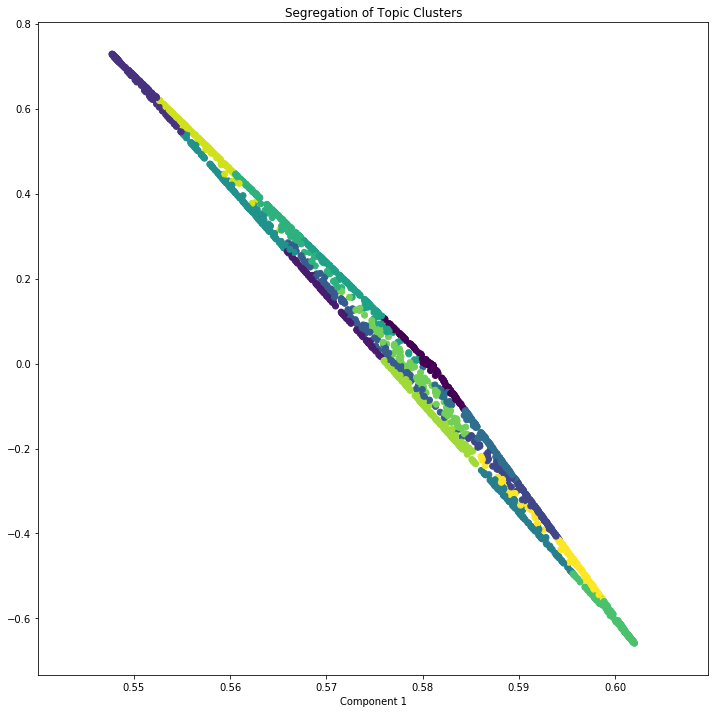

In [25]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [26]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [28]:
# Get similar documents
mytext = ["Blue Dream, a sativa-dominant hybrid originating in California, has achieved legendary status among West Coast strains. Crossing a Blueberry indica with the sativa Haze, Blue Dream balances full-body relaxation with gentle cerebral invigoration. Novice and veteran consumers alike enjoy the level effects of Blue Dream, which ease you gently into a calm euphoria. Some Blue Dream phenotypes express a more indica-like look and feel, but the sativa-leaning variety remains most prevalent."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['sativa', 'hybrid', 'haze', 'sweet', 'aroma', 'sour', 'flower', 'bud', 'diesel', 'genetic', 'cerebral', 'blue', 'lemon', 'cooky', 'breed']
Topic Prob Scores of text:  [[0.2 0.8 0. ]]
Most Similar Doc's Probs:   [[0.2 0.8 0. ]]

 blackberry haze developed nebu hybridz sativa hybrid blackberry lime haze unlike sibling blackberry lime haze phenotype take blackberry parent twisting purple calyx sweet berry aroma note violet spice cocoa detected sativa s frost covered bud day productivity paramount blackberry haze offer clear unencumbered relief will typically leave motivation tact
